In [1]:
import sys 
# locate to the working folder
sys.path.append("D:\\GitHub\\Clone\\planning\\ruixuan")
from turning_scene import *
from l5kit.rasterization.rasterizer_builder import _load_metadata
import time
import pickle

D:\Anaconda\lib\site-packages\l5kit\dataset\select_agents.py:31: UserWarning: Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows.However, writing the mask with this config may be inconsistent.
  "Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows."


In [2]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "C:\\Users\\zheng\\Desktop\\UMich\\Independent Study\\prediction-dataset"
# get config
cfg = load_config_data("C:\\Users\\zheng\\Desktop\\UMich\\Independent Study\\Codes\\python codes\\visualisation_config.yaml")
print(cfg)

dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

rast = build_rasterizer(cfg, dm)
ego_dataset = EgoDataset(cfg, zarr_dataset, rast)
# agent_dataset = AgentDataset(cfg, zarr_dataset, rast)
# Obatin the information from semantic map

semantic_map_filepath = dm.require(cfg["raster_params"]["semantic_map_key"])
dataset_meta = _load_metadata(cfg["raster_params"]["dataset_meta_key"], dm)
world_to_ecef = np.array(dataset_meta["world_to_ecef"], dtype=np.float64)
Map_Api = MapAPI(semantic_map_filepath, world_to_ecef)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'future_num_frames': 50, 'step_time': 0.1}, 'raster_params': {'raster_size': [300, 300], 'pixel_size': [0.5, 0.5], 'ego_center': [0.6, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'val_data_loader': {'key': 'scenes/train_full.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}}
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-

In [3]:
class Trajectory(Scene):
    
    def __init__(self, dataset, Map_Api):
        super(Trajectory, self).__init__(dataset, Map_Api)
        self.label_name = ['Car','Van','Tram','Bus','Truck','EV','OV','Bicycle','Motorcycle','Cyclist','Motorcyclist','Pedestrian']
        self.label_idx = list(range(3,15))
        self.label_dict = dict(zip(self.label_name, self.label_idx))
        self.all_traffic_control = None
        self.Traffic_Control = None

    def generate_info_from_MAP(self):
        self.all_junctions = self.get_elements("junction")
        self.all_lanes = self.get_elements("lane")
        self.all_traffic_control = self.get_elements("traffic_control_element")
        self.Lane = {self.map_api.id_as_str(lane.id):lane.element.lane for lane in self.all_lanes}
        self.Junction = {self.map_api.id_as_str(junction.id):junction for junction in self.all_junctions}
        self.Traffic_Control = {self.map_api.id_as_str(traffic_control.id):traffic_control.element for traffic_control in self.all_traffic_control}
        
        for junction in self.all_junctions:
            self.Junction_Lane[self.map_api.id_as_str(junction.id)] = []

            for lane in junction.element.junction.lanes:
                self.Junction_Lane[self.map_api.id_as_str(junction.id)].append(self.map_api.id_as_str(lane))

            self.Junction_Lane[self.map_api.id_as_str(junction.id)] = set(self.Junction_Lane[self.map_api.id_as_str(junction.id)])
        
        self.junction_scene = dict.fromkeys(list(self.Junction.keys()), [])
        self.junction_turning_scene = dict.fromkeys(list(self.Junction.keys()), {})
        for key in self.Junction.keys():
            self.junction_turning_scene[key] = {'Turning Left': [], 'Turning Right': []}    
        
        
    def label_loc_check(self, target_label):
    
        agent_id_list = self.agent_list[self.label_dict[target_label]-3]

        for agent_id in agent_id_list:
            agent_loc = self.agent_centroid[np.where(self.agent_id==agent_id)[0]]
            for centroid in agent_loc:
                if self.Junction_region.contains(Point(centroid[0],centroid[1])):
                    return True
    
    def junction_lane_visualize(self, junction_id):
        
        plt.figure(figsize=(18,18))
        
        lane_list = self.Junction_Lane[junction_id]
        
        for lane in lane_list:
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_left'][:,0].tolist()+ self.map_api.get_lane_coords(lane)['xyz_right'][:,0].tolist(),
                        self.map_api.get_lane_coords(lane)['xyz_left'][:,1].tolist()+ self.map_api.get_lane_coords(lane)['xyz_right'][:,1].tolist(),
                        marker='x', label = lane)

        plt.axis("equal")
        plt.grid(which='both')
        plt.legend(fontsize=20)
        axes = plt.gca()  
    
                
    def agent_trajectory(self, scene, target_label, junction_boundary):

        self.scene = scene
        self.target_label = target_label
#         self.junction = junction
        # region for junction "sGK1"
#         junction_boundary = {junction:[(300,-1150),[300,-1100],(340,-1100),(340,-1150)]}

        # region for junction "8KfB"
#         junction_boundary = {junction:[(500,-2420),(500,-2360),(560,-2360),(560,-2420)]}
        
        # region for lane merge
#         junction_boundary = {junction:[(-940,1380),(-940,1480),(-880,1380),(-880,1480)]}

        self.Junction_region = Polygon(junction_boundary)

        self.agent_list = []
        frame_interval = self.dataset.scenes[scene]['frame_index_interval']
        agent_interval_begin = self.dataset.frames[frame_interval[0]]['agent_index_interval'][0]
        agent_interval_end = self.dataset.frames[frame_interval[1]-1]['agent_index_interval'][1]
        self.agent_id = self.dataset.agents[agent_interval_begin:agent_interval_end]['track_id']
        agent_label_prob = self.dataset.agents[agent_interval_begin:agent_interval_end]['label_probabilities']
        self.agent_centroid = self.dataset.agents[agent_interval_begin:agent_interval_end]['centroid']

        for label in self.label_idx:
            valid_idx = np.where(agent_label_prob[:,label]>0.5)[0]
            valid_id = set(self.agent_id[valid_idx])
            self.agent_list.append(list(valid_id))

        if len(self.agent_list[self.label_dict[target_label]-3])>0 and self.label_loc_check(target_label):
            return [scene]
        else:
            # print('Not feasible scene')
            return []
            
            
            
    def trajectory_junction_visualize(self, scene, target_label, junction, lane_list):
        
        frame_interval = self.dataset.scenes[scene]['frame_index_interval']
        
        plt.figure(figsize=(18,18))

        for lane in lane_list:
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_right'][:,0], self.map_api.get_lane_coords(lane)['xyz_right'][:,1],
                     color='k',linewidth=5, alpha=0.2)
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_left'][:,0], self.map_api.get_lane_coords(lane)['xyz_left'][:,1],
                     color='k',linewidth=5, alpha=0.2)

        cmap = plt.get_cmap('gnuplot')    
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
         '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','maple','yellowgreen'] 

        for idx, agent_label in enumerate(self.agent_list):
            for agent in agent_label:
                agent_loc = self.agent_centroid[np.where(self.agent_id==agent)[0]]
                if idx != self.label_dict[target_label]-3 and agent_loc.shape[0] > 30  and np.linalg.norm(agent_loc[0,:]-agent_loc[-1,:]) > 5:
                    plt.plot(agent_loc[:,0],agent_loc[:,1],label='Agent ID '+str(agent)+': '+self.label_name[idx], color=colors[idx])

                elif idx== self.label_dict[target_label]-3:
                    plt.plot(agent_loc[:,0],agent_loc[:,1], color=colors[idx], marker='*')

        ego_translation = self.frames[frame_interval[0]:frame_interval[1]]['ego_translation']
        plt.plot(ego_translation[:,0],ego_translation[:,1],label='Ego',color='r')
        turn = ' Left Turn' if rotation33_as_yaw(self.frames[frame_interval[0]]['ego_rotation']) - rotation33_as_yaw(self.frames[frame_interval[1]-1]['ego_rotation']) < 0 else ' Right Turn'

        plt.axis("equal")
        plt.grid(which='both')
        plt.legend(fontsize=20,loc='best')
        plt.title('Trajectory : Scene '+str(scene)+turn+' at Junction '+junction, fontsize=30)
        axes = plt.gca()
        
#     def agents_state_find(self, scene, output_array, target_agent_type_list):
        
#         frame_interval = .dataset.scenes[scene]['frame_index_interval']
        
#         cars_list = target_agent_type_list[0]
#         pedestrian_list = target_agent_type_list[1]
        
#         for agent_list in target_agent_type_list:
#             for agent in agent_list:
#                     agent_loc = self.agent_centroid[np.where(self.agent_id==agent)[0]]
#                     if idx != self.label_dict[target_label]-3 and agent_loc.shape[0] > 30  and np.linalg.norm(agent_loc[0,:]-agent_loc[-1,:]) > 5:
#                         for frame in frames

#                     elif idx== self.label_dict[target_label]-3:
#                         plt.plot(agent_loc[:,0],agent_loc[:,1], color=colors[idx], marker='*')

In [4]:
Test = Trajectory(zarr_dataset, Map_Api)
Test.generate_info_from_MAP()

In [6]:
junction_lane_merge = np.load('ruixuan//target_scene_index//lane_merge//scene_index(lane_merge)_Pedestrian.npy',allow_pickle = True)
junction_8KfB = np.load('ruixuan//target_scene_index//8KfB//scene_index(8KfB)_Pedestrian.npy',allow_pickle = True)

In [7]:
def plot_trajectory(intersection_id, scene, lane_list, junction_boundary):

    Test.agent_trajectory(scene, 'Pedestrian', junction_boundary[intersection_id])
    Test.trajectory_junction_visualize(scene, 'Pedestrian', intersection_id, lane_list[intersection_id])

In [512]:
# Manully find the lane id in Map_Api for "lane_merge" and "8KfB"
lane_list = {}
junction_boundary = {}
lane_list['lane_merge'] = ['ADrl',"oFEC",'m0JU','iQgg','M5V5','/Pgg','FFEC','XHTU']
lane_list['8KfB'] = ['/24B','6p63','FV1O','MV/U','SxVb','TG2b','TZZv','ZnUV','bH1o','dddQ','nXc0','zHjP','SD8o','vC8o']
junction_boundary['lane_merge'] = [(-940,1380),(-940,1480),(-880,1380),(-880,1480)]
junction_boundary['8KfB'] = [(500,-2420),(500,-2360),(560,-2360),(560,-2420)]

def plot_intersection_boundary(intersection_id, lane_list, lane_sequence):
    
    extra_lane = list(lane_sequence.keys())
    
    original_lane = lane_list['8KfB']
    
    plt.figure(figsize=(18,18))
#     for lane in lane_list[intersection_id]:


    for lane in extra_lane:
        plt.plot(Test.map_api.get_lane_coords(lane)['xyz_right'][:,0], Test.map_api.get_lane_coords(lane)['xyz_right'][:,1],
                 color='r',linewidth=5,label=lane)
        plt.plot(Test.map_api.get_lane_coords(lane)['xyz_left'][:,0], Test.map_api.get_lane_coords(lane)['xyz_left'][:,1],
                 color='r',linewidth=5)
        
    for lane in original_lane:
        plt.plot(Test.map_api.get_lane_coords(lane)['xyz_right'][:,0], Test.map_api.get_lane_coords(lane)['xyz_right'][:,1],
                 color='g',linewidth=5,label=lane,alpha = 0.5)
        plt.plot(Test.map_api.get_lane_coords(lane)['xyz_left'][:,0], Test.map_api.get_lane_coords(lane)['xyz_left'][:,1],
                 color='g',linewidth=5,alpha = 0.5)
    plt.title(intersection_id,fontsize=30)
        
    plt.scatter([550,515], [-2370,-2390])    

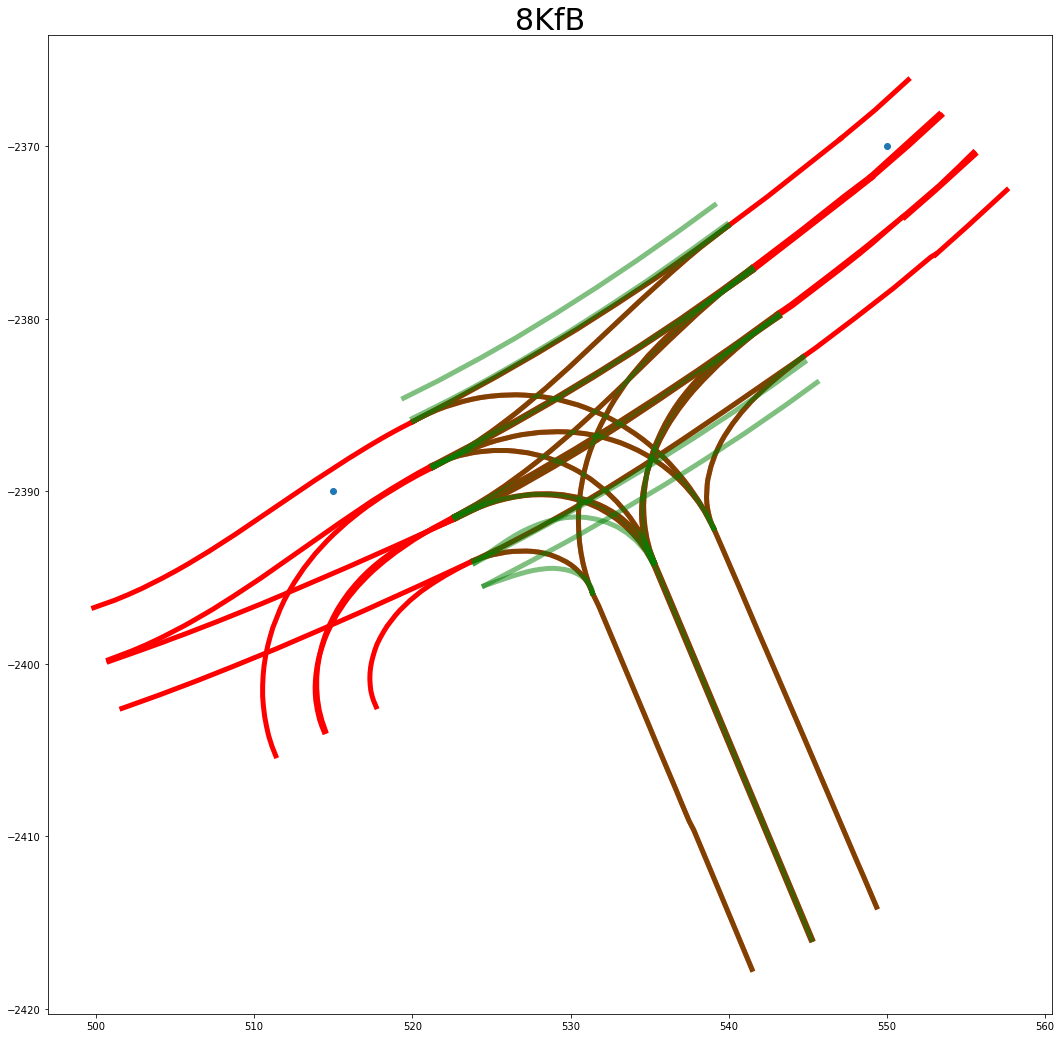

In [513]:
plot_intersection_boundary('8KfB', lane_list, lane_sequence)

In [509]:
lane_collision_check([550,-2370],[515,-2390])

False

In [508]:
def lane_find(centroid):
    lane_list = []
    for key, value in Test.Lane.items():
            if Test.lane_check(centroid, key):
                lane_list.append(key)
                
    return lane_list


def lane_collision_check(previous_point, next_point):
    lane_sequence = {}
    lane_sequence['vC8o'] = ['vC8o','FV1O','5iGz','ggJO','ZnUV','Ddbj','ehXw','MV/U','iUTK','QtJ5']
    lane_sequence['FV1O'] = ['FV1O','5iGz','ggJO']
    lane_sequence['5iGz'] = ['5iGz','ggJO']
    lane_sequence['ggJO'] = ['ggJO']
    
    lane_sequence['ZnUV'] = ['ZnUV','Ddbj','ehXw']
    lane_sequence['Ddbj'] = ['Ddbj','ehXw']
    lane_sequence['ehXw'] = ['ehXw']
    
    lane_sequence['MV/U'] = ['MV/U','iUTK','QtJ5']
    lane_sequence['iUTK'] = ['iUTK','QtJ5']
    lane_sequence['QtJ5'] = ['QtJ5']

    lane_sequence['PT2k'] = ['PT2k','kebj','nXc0','5iGz','ggJO']
    lane_sequence['kebj'] = ['kebj','nXc0','5iGz','ggJO']
    lane_sequence['nXc0'] = ['nXc0','5iGz','ggJO']
    
    lane_sequence['/eJO'] = ['/eJO','YhGz','zHjP','SxVb' ,'iUTK','QtJ5','Ddbj','ehXw']
    lane_sequence['YhGz'] = ['YhGz','zHjP','SxVb' ,'iUTK','QtJ5','Ddbj','ehXw']
    lane_sequence['zHjP'] = ['zHjP','SxVb' ,'iUTK','QtJ5','Ddbj','ehXw']
    
    lane_sequence['SxVb'] = ['SxVb' ,'Ddbj','ehXw']
    lane_sequence['Ddbj'] = ['Ddbj','ehXw']
    lane_sequence['ehXw'] = ['ehXw']
    
    lane_sequence['zHjP'] = ['zHjP','QtJ5']
    lane_sequence['QtJ5'] = ['QtJ5']
    
   
    lane_sequence['MBVy'] = ['MBVy','kebj','TG2b','SD8o']
    lane_sequence['kebj'] = ['kebj','TG2b','SD8o']
    lane_sequence['TG2b'] = ['TG2b','SD8o']
    lane_sequence['SD8o'] = ['TG2b','SD8o']
    
    
    lane_sequence['nfm2'] = ['nfm2','upKw','/24B','bH1o','SD8o']
    lane_sequence['upKw'] = ['upKw','/24B','bH1o','SD8o']
    lane_sequence['/24B'] = ['/24B','bH1o','SD8o']
    lane_sequence['bH1o'] = ['bH1o','SD8o']
    lane_sequence['SD8o'] = ['SD8o']
    lane_sequence['/24B'] = ['/24B']
    
    
    ################################################################
    # check the lane collison: True for lane collision and False for no lane collision
    
    # given a location, find out all lanes, including overlapped ones 
    previous_lane_list = lane_find(previous_point)
    next_lane_list = lane_find(next_point)
    
    # index 0 for not in the intersection and 1 for in the intersection
    previous_index = 0
    next_index = 0
    for lane in previous_lane_list:
        if lane in list(lane_sequence.keys()):
            previous_index = 1
            
    for lane in next_lane_list:
        if lane in list(lane_sequence.keys()):
            next_index = 1
        
    if previous_index+next_index != 2:
        return False
    else:
        for lane in previous_lane_list:
            for next_lane in next_lane_list:
                if (lane in list(lane_sequence.keys())) and (next_lane in lane_sequence[lane]):
                    return False
            else:
                return True